<a href="https://colab.research.google.com/github/utsavnandi/Kaggle-SIIM-ISIC-Melanoma-Classification/blob/master/SIIM_ISIC_Melanoma_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## One-time


In [0]:
%%writefile setup.sh
pip uninstall kaggle -y
pip install kaggle==1.5.6 -q
pip install -U git+https://github.com/albu/albumentations -q
pip install -U git+https://github.com/rwightman/pytorch-image-models -q
pip install neptune-client -q
mkdir ~/.kaggle/
cp ./kaggle.json  ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download tunguz/siimisic-melanoma-resized-images -f x_train_224.npy
kaggle datasets download tunguz/siimisic-melanoma-resized-images -f x_test_224.npy
unzip ./680899%2F1200702%2Fcompressed%2Fx_train_224.npy.zip -d ./data/
unzip ./680899%2F1200702%2Fcompressed%2Fx_test_224.npy.zip -d ./data/
rm ./680899%2F1200702%2Fcompressed%2Fx_train_224.npy.zip
rm ./680899%2F1200702%2Fcompressed%2Fx_test_224.npy.zip
kaggle competitions download siim-isic-melanoma-classification -f sample_submission.csv
kaggle competitions download siim-isic-melanoma-classification -f test.csv
kaggle competitions download siim-isic-melanoma-classification -f train.csv
unzip train.csv -d ./data/
mv ./test.csv ./data/
mv ./sample_submission.csv ./data/
rm train.csv.zip
mkdir ./logs/

Writing setup.sh


In [0]:
%%time
!sh setup.sh

## Setup

In [0]:
import os
import gc
import time
import datetime
import random
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import auth
from google.cloud import storage

from sklearn.model_selection import train_test_split#, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
#from torch.utils.tensorboard import SummaryWriter

import timm
#from sampler import BalancedBatchSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
#from aug_mix import RandomAugMix

import neptune

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(43)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
PROJECT_ID = getpass(prompt='Enter gcp project id: ')
bucket_name = getpass(prompt='Enter gcp bucket name: ')

if PROJECT_ID != '' and bucket_name !='':
    auth.authenticate_user()

!gcloud config set project {PROJECT_ID}

if PROJECT_ID != '' and bucket_name !='':
    storage_client = storage.Client(project=PROJECT_ID)

def upload_blob(source_file_name, destination_blob_name, bucket_name=bucket_name, PROJECT_ID=PROJECT_ID):
    """Uploads a file to the bucket."""
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print("File {} uploaded to {}.".format(source_file_name, destination_blob_name))

Enter gcp project id: ··········
Enter gcp bucket name: ··········
Enter neptune api token: ··········
Updated property [core/project].


In [0]:
NEPTUNE_API_TOKEN = getpass(prompt='Enter neptune api token: ')

if NEPTUNE_API_TOKEN != '':
    os.environ['NEPTUNE_API_TOKEN'] = NEPTUNE_API_TOKEN
    log = True

In [0]:
DATA_DIR = '/content/data/'

In [0]:
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
train_images = np.load(DATA_DIR+'x_train_224.npy') #x_train_128
train_labels = df_train['target']
test_images = np.load(DATA_DIR+'x_test_224.npy') #x_test_128

In [0]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels.values, 
    test_size=0.3, random_state=43,
    stratify=train_labels,
)
del train_images, train_labels
gc.collect()
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (23188, 224, 224, 3)
y_train (23188,)
X_val (9938, 224, 224, 3)
y_val (9938,)


In [0]:
print('Train target distribution: ')
print(pd.Series(y_train).value_counts())
print('Val target distribution: ')
print(pd.Series(y_val).value_counts())
#55.694376

Train target distribution: 
0    22779
1      409
dtype: int64
Val target distribution: 
0    9763
1     175
dtype: int64


## Dataset

In [0]:
class MelanomaDataset(Dataset):
    def __init__(self, img_arr, labels, isEval=False, transform=None):
        super().__init__()
        self.images = img_arr
        self.transform = transform
        self.isEval = isEval
        if not self.isEval:
            self.labels = labels
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image = self.images[index].astype(np.uint8)

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image']
        else:
            image = np.transpose(image, (2, 1, 0))
        
        if self.isEval:
            return image
        target = self.labels[index].astype(np.float32)
        return image, target


## Augmentations

In [0]:
#%%writefile augmentations.txt
# Transforms
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

def strong_aug(p=1.0):
    return A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        #A.OneOf([
        #    A.IAAAdditiveGaussianNoise(),
        #    A.GaussNoise(),
        #], p=0.3),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.3),
        ], p=0.3),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.3),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.MultiplicativeNoise(multiplier=[0.8, 1.2], elementwise=True, p=0.5),
        A.RandomGridShuffle(grid=(3, 3), p=1),
        A.Cutout(num_holes=1, max_h_size=64, max_w_size=64, p=0.5),
        A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
        ToTensorV2(p=1.0),
    ], p=p)

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
        ToTensorV2(p=1.0),
    ])

## Visualise Transforms

In [0]:
def visualize_dataset(dataset, shuffle=True):
    dl = DataLoader(dt, batch_size=4, shuffle=shuffle)
    for images, targets in dl:
        for image, target in zip(images, targets):
            print(image.shape)
            image = image.float().detach().numpy().transpose((1,2,0))
            target = target.detach().numpy()
            print('Mean', np.mean(image))
            print('std', np.std(image))
            #print(image)
            plt.imshow(image, vmin=-1, vmax=1)
            plt.show()
            print(target)
        break

#dt = MelanomaDataset(X_train[:32], y_train[:32], isEval=False, transform=strong_aug())
#visualize_dataset(dt, False)

## RoC plot

In [0]:
def plot_roc(y_true, y_pred, show=False):
    testy, lr_probs = y_true, y_pred
    ns_probs = [0 for _ in range(len(testy))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs) #lr_probs: predictions
    # plot the roc curve for the model
    plt.figure(figsize=(8,8))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, linestyle='-', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    #save
    filename = f'/content/logs/roc_curve_{datetime.datetime.now().strftime("%d-%m-%Y-%HH-%MM")}.png'
    plt.savefig(filename)
    # show the plot
    if show:
        plt.show()
    else:
        plt.clf()
    return filename

## Model

In [0]:
class ResNet34Mod(nn.Module): 

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet34(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)
    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class ResNet50Mod(nn.Module): 

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)
    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b0(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b0', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b0_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b0', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b1(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b1', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class Tf_efficientnet_b1_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b1', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class swsl_resnext101_32x4d(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('swsl_resnext101_32x4d', pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class swsl_resnext101_32x4d_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('swsl_resnext101_32x4d', pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class gluon_seresnext50_32x4d(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('gluon_seresnext50_32x4d', pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)

class gluon_seresnext50_32x4d_Mod(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('gluon_seresnext50_32x4d', pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, int(in_features/2))
        self.bn_1 = nn.BatchNorm1d(int(in_features/2))
        self.relu_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        self.fc_2 = nn.Linear(int(in_features/2), 1)

    def forward(self, x):
        x = self.model(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.drop_1(x)
        x = self.fc_2(x)
        return x

class Tf_efficientnet_b5(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b5', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.model(x)


## Custom Losses

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

## Train script

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def criterion(y_pred, y_true):
    return nn.BCEWithLogitsLoss(
    #    pos_weight=torch.tensor([22779/409], dtype=torch.float).to(device)
    )(y_pred, y_true)
    #return FocalLoss()(y_pred, y_true)

def get_datasets(X_train, y_train, X_val, y_val):
    datasets = {}
    datasets['train'] = MelanomaDataset(
        X_train, y_train, isEval=False, transform=strong_aug()
    ) #strong_aug get_train_transform
    datasets['valid'] = MelanomaDataset(
        X_val, y_val, isEval=False, transform=get_valid_transform()
    )
    return datasets

def train_one_epoch(loader, model, optimizer, epoch, scheduler=None, amp_use=False, log=True):
    model.train()
    running_loss = 0.0
    for idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)): #
        images = images.to(device)
        targets = targets.to(device).unsqueeze(1)

        optimizer.zero_grad()

        y_pred = model(images.float())
        loss = criterion(y_pred, targets)
        running_loss += float(loss)
        
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()
        
        if log:
            neptune.log_metric("Loss/train", loss) #epoch * len(loader) + idx
        #if (idx % FLAGS['log_interval'] == 0) and (idx % len(loader) != 0):
        #    print(f"Iteration #{idx} loss: {loss}")

    return running_loss/len(loader)

def val_one_epoch(loader, model):
    model.eval()
    running_loss = 0.0
    y_preds_list = []
    targets_list = []
    with torch.no_grad():
        for idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)):
            images = images.to(device)
            targets = targets.to(device).unsqueeze(1)
            
            y_pred = model(images.float())
            loss = criterion(y_pred, targets)
            
            running_loss += float(loss)
            y_preds_list.append(torch.sigmoid(y_pred).cpu().numpy())
            targets_list.append(targets.cpu().numpy())
        y_true = np.vstack(targets_list)
        y_pred = np.vstack(y_preds_list)
        auc_score = roc_auc_score(y_true, y_pred)
        roc_plot = plot_roc(y_true, y_pred)
        print(f'roc_auc_score: {auc_score}')
        print(f'average loss for val epoch: {running_loss/len(loader)}')
    return running_loss/len(loader), auc_score, roc_plot
   
def save_upload(model, optimizer, best_score, epoch, fold=None, exp_name='model'):
    if fold:
        NAME = 'siim-isic_'+exp_name+f'_fold_{fold}_{str(epoch+1)}.ckpt'
    NAME = 'siim-isic_'+exp_name+f'_{str(epoch+1)}.ckpt'
    MODEL_PATH = NAME
    torch.save({
        #'epoch': epoch,
        'model_state_dict': model.state_dict(),
        #'optimizer_state_dict': optimizer.state_dict(),
    }, MODEL_PATH)
    print(f"Saved ckpt for epoch {epoch+1}, new best score: {best_score}")
    upload_blob(MODEL_PATH, NAME)
    print(f"Uploaded ckpt for epoch {epoch+1}")

In [0]:
FLAGS = {}
FLAGS['batch_size'] = 32
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 3e-4 #FLAGS['learning_rate'] = 3e-3
FLAGS['num_epochs'] = 10
FLAGS['weight_decay'] = 1e-3
FLAGS['momentum'] = 0.9
FLAGS['log_interval'] = 175
FLAGS['img_size'] = 224
FLAGS['loss'] = 'BCE unbalanced'
FLAGS['optimizer'] = 'AdamW'
FLAGS['exp_name'] = 'Tf_efficientnet_b5'
exp_description = '''
Tf_efficientnet_b5 with base head,
RandomWeightedSampler,
RandomGridShuffle + strong_aug p=1.0,
imsize 224
'''
def train_job(X_train, y_train, X_val, y_val, log=True):
    exp_name = FLAGS['exp_name']
    best_score = 0.0
    #model = ResNet34Mod().to(device)
    #model = ResNet50Mod().to(device)
    #model = Tf_efficientnet_b0().to(device)
    #model = Tf_efficientnet_b0_Mod().to(device)
    #model = Tf_efficientnet_b1().to(device)
    #model = Tf_efficientnet_b1_Mod().to(device)
    model = Tf_efficientnet_b5().to(device)
    #model = swsl_resnext101_32x4d().to(device)
    #model = gluon_seresnext50_32x4d().to(device)
    if log:
        neptune.init('utsav/SIIM-ISIC', api_token=NEPTUNE_API_TOKEN)
        neptune.create_experiment(
            exp_name, exp_description, params=FLAGS,
            upload_source_files='*.txt'
        )
    
    #optimizer = torch.optim.SGD(
    #    model.parameters(), lr=FLAGS['learning_rate'], 
    #    momentum=FLAGS['momentum'], 
    #    weight_decay=FLAGS['weight_decay']
    #)
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=FLAGS['learning_rate'], 
        weight_decay=FLAGS['weight_decay']
    )

    # scheduler = ...
    # todo ...
    
    datasets = get_datasets(X_train, y_train, X_val, y_val)
    
    #sampler
    labels_vcount = pd.Series(y_train).value_counts()
    class_counts = [labels_vcount[0].astype(np.float32), labels_vcount[1].astype(np.float32)]
    num_samples = sum(class_counts)
    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[y_train[i]] for i in range(int(num_samples))]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    #loaders
    train_loader = DataLoader(
        datasets['train'], batch_size=FLAGS['batch_size'], 
        num_workers=FLAGS['num_workers'],
        sampler=sampler,
        pin_memory=True,
        #shuffle=True,
    )
    val_loader = DataLoader(
        datasets['valid'], batch_size=32, shuffle=False, 
        num_workers=FLAGS['num_workers'], drop_last=True
    )

    #train loop
    for epoch in range(0, FLAGS['num_epochs']):

        print('-'*27 + f'Epoch #{epoch+1} started' + '-'*27)
        #with torch.autograd.profiler.profile(use_cuda=True) as prof:
        train_loss = train_one_epoch(
            train_loader, 
            model, optimizer, 
            epoch, scheduler=None, 
            amp_use=None, log=log
        )
        #print(prof)
        print()
        print(f'Average loss for epoch #{epoch+1} : {train_loss}')
        val_loss, auc_score, roc_plot = val_one_epoch(val_loader, model)
        
        #logs
        if log:
            neptune.log_metric('AUC/val', auc_score)
            neptune.log_image('ROC/val', roc_plot)
            neptune.log_metric('Loss/val', val_loss)

        #checkpoint+upload
        if (auc_score > best_score) or (best_score-auc_score<0.005):
            best_score = auc_score
            save_upload(
                model, optimizer, 
                best_score, epoch, 
                exp_name=exp_name
            )
            
        print('-'*28 + f'Epoch #{epoch+1} ended' + '-'*28)
    if log:
        neptune.stop()
    return model

## Train

In [0]:
log = True
try:
    trained_model = train_job(X_train, y_train, X_val, y_val, log=log)
except Exception as e:
    if log:
        neptune.stop()
    print(e)
except KeyboardInterrupt:
    if log:
        neptune.stop()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth


https://ui.neptune.ai/utsav/SIIM-ISIC/e/SIIM-55
---------------------------Epoch #1 started---------------------------


100%|██████████| 725/725 [06:48<00:00,  1.77it/s]


Average loss for epoch #1 : 0.4167374356039639



100%|██████████| 310/310 [00:39<00:00,  7.78it/s]


roc_auc_score: 0.8682946566004546
average loss for val epoch: 0.21166253113938915
Saved ckpt for epoch 1, new best score: 0.8682946566004546
File siim-isic_Tf_efficientnet_b5_1.ckpt uploaded to siim-isic_Tf_efficientnet_b5_1.ckpt.
Uploaded ckpt for epoch 1
----------------------------Epoch #1 ended----------------------------
---------------------------Epoch #2 started---------------------------


100%|██████████| 725/725 [06:48<00:00,  1.77it/s]


Average loss for epoch #2 : 0.30667224817234895



100%|██████████| 310/310 [00:39<00:00,  7.79it/s]


roc_auc_score: 0.838527010188375
average loss for val epoch: 0.2461672340549769
----------------------------Epoch #2 ended----------------------------
---------------------------Epoch #3 started---------------------------


100%|██████████| 725/725 [06:49<00:00,  1.77it/s]


Average loss for epoch #3 : 0.24124044241062526



100%|██████████| 310/310 [00:39<00:00,  7.78it/s]


roc_auc_score: 0.8212803635564025
average loss for val epoch: 0.21617006565173788
----------------------------Epoch #3 ended----------------------------
---------------------------Epoch #4 started---------------------------


100%|██████████| 725/725 [06:48<00:00,  1.77it/s]


Average loss for epoch #4 : 0.20636305017717954



100%|██████████| 310/310 [00:39<00:00,  7.77it/s]


roc_auc_score: 0.8797795206332917
average loss for val epoch: 0.2220627899972662
Saved ckpt for epoch 4, new best score: 0.8797795206332917
File siim-isic_Tf_efficientnet_b5_4.ckpt uploaded to siim-isic_Tf_efficientnet_b5_4.ckpt.
Uploaded ckpt for epoch 4
----------------------------Epoch #4 ended----------------------------
---------------------------Epoch #5 started---------------------------


100%|██████████| 725/725 [06:48<00:00,  1.77it/s]


Average loss for epoch #5 : 0.1713743394176508



100%|██████████| 310/310 [00:39<00:00,  7.78it/s]


roc_auc_score: 0.8638610276332184
average loss for val epoch: 0.18198532536776074
----------------------------Epoch #5 ended----------------------------
---------------------------Epoch #6 started---------------------------


100%|██████████| 725/725 [06:50<00:00,  1.77it/s]


Average loss for epoch #6 : 0.1483887051855182



100%|██████████| 310/310 [00:39<00:00,  7.77it/s]


roc_auc_score: 0.8662851279044198
average loss for val epoch: 0.16714327733892376
----------------------------Epoch #6 ended----------------------------
---------------------------Epoch #7 started---------------------------


100%|██████████| 725/725 [06:48<00:00,  1.77it/s]


Average loss for epoch #7 : 0.1368120440095663



100%|██████████| 310/310 [00:39<00:00,  7.77it/s]


roc_auc_score: 0.8775489261892545
average loss for val epoch: 0.15950632051775052
Saved ckpt for epoch 7, new best score: 0.8775489261892545
File siim-isic_Tf_efficientnet_b5_7.ckpt uploaded to siim-isic_Tf_efficientnet_b5_7.ckpt.
Uploaded ckpt for epoch 7
----------------------------Epoch #7 ended----------------------------
---------------------------Epoch #8 started---------------------------


100%|██████████| 725/725 [06:51<00:00,  1.76it/s]


Average loss for epoch #8 : 0.12119423201500341



100%|██████████| 310/310 [00:39<00:00,  7.77it/s]


roc_auc_score: 0.8592661438100124
average loss for val epoch: 0.12052471353832046
----------------------------Epoch #8 ended----------------------------
---------------------------Epoch #9 started---------------------------


100%|██████████| 725/725 [06:49<00:00,  1.77it/s]


Average loss for epoch #9 : 0.1110497453847322



100%|██████████| 310/310 [00:39<00:00,  7.77it/s]


roc_auc_score: 0.8451525324342153
average loss for val epoch: 0.15112195101720582
----------------------------Epoch #9 ended----------------------------
---------------------------Epoch #10 started---------------------------


 70%|███████   | 509/725 [04:49<02:05,  1.72it/s]

## Inference

In [0]:
#trained_model = ResNet34Mod()
def run_test(model, test_images, ckpts):
    agg_predictions = []
    for ckpt in ckpts:
        model.load_state_dict(torch.load(ckpt)['model_state_dict'])
        model.to(device).eval()
        test_dataset = MelanomaDataset(test_images, labels=None, isEval=True, transform=get_valid_transform())
        test_data_loader = DataLoader(
            test_dataset, batch_size=256, shuffle=False, 
            num_workers=4, pin_memort=True
        )
        predictions = []
        with torch.no_grad():
            for images in tqdm(test_data_loader, total=len(test_data_loader)):
                images = images.to(device)
                y_pred = torch.sigmoid(model(images.float()))
                predictions.append(y_pred.cpu().numpy())
        predictions = np.vstack(predictions)
        plt.hist(predictions.T[0],bins=100)
        plt.ylim((0,500))
        plt.show()
        agg_predictions.append(predictions)
    #can be vectorized
    avg_predictions = agg_predictions[0]
    for i in range(1, len(agg_predictions)):
        avg_predictions+=agg_predictions[i]
    avg_predictions/=len(agg_predictions)
    print('average:')
    plt.hist(avg_predictions.T[0],bins=100)
    plt.ylim((0,500))
    plt.show()
    return avg_predictions

100%|██████████| 43/43 [00:16<00:00,  2.56it/s]


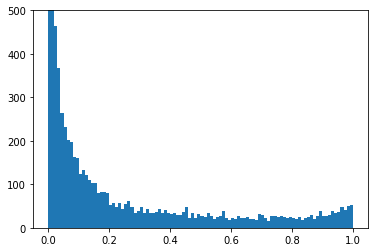

100%|██████████| 43/43 [00:16<00:00,  2.56it/s]


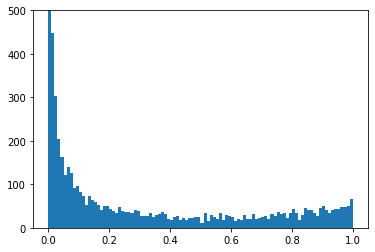

average:


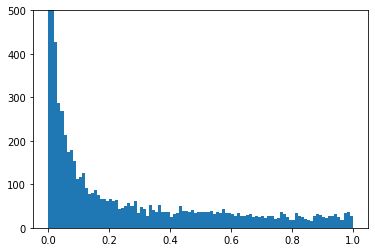

In [0]:
ckpts = [
         '/content/siim-isic_Tf_efficientnet_b1_Mod_2.ckpt',
         '/content/siim-isic_Tf_efficientnet_b1_Mod_4.ckpt',
         ]
#model = swsl_resnext101_32x4d_Mod().to(device)
avg_predictions = run_test(trained_model, test_images, ckpts)

In [0]:
diff = avg_predictions - avg_predictions_eff0
eff_res_avg = (avg_predictions + avg_predictions_eff0) / 2

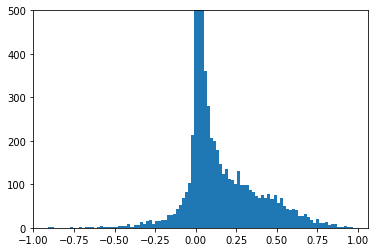

In [0]:
plt.hist(diff.T[0],bins=100)
plt.ylim((0,500))
plt.show()

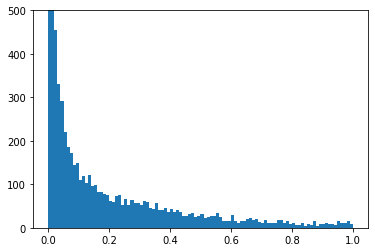

In [0]:
plt.hist(eff_res_avg.T[0],bins=100)
plt.ylim((0,500))
plt.show()

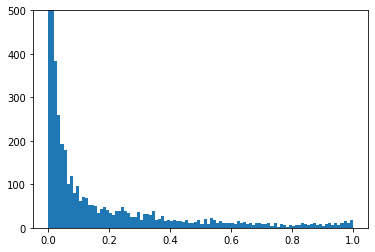

In [0]:
#enet_b0_6+8+9

In [0]:
pd.Series(avg_predictions.T[0]).describe()

count    1.098200e+04
mean     1.127915e-01
std      1.964244e-01
min      2.191101e-08
25%      4.212644e-04
50%      1.386940e-02
75%      1.346696e-01
max      9.978799e-01
dtype: float64

In [0]:
pd.Series(np.where(avg_predictions>0.5,1,0).T[0]).value_counts()

0    10250
1      732
dtype: int64

In [0]:
sample_submission.target = avg_predictions.T[0].T

In [0]:
sample_submission.to_csv('submission.csv', index=False)

In [0]:
pd.read_csv('submission.csv')

,image_name,target
0,ISIC_0052060,0.000975
1,ISIC_0052349,0.000237
2,ISIC_0058510,0.000002
3,ISIC_0073313,0.000003
4,ISIC_0073502,0.029049
...,...,...
10977,ISIC_9992485,0.002577
10978,ISIC_9996992,0.445219
10979,ISIC_9997917,0.135978
10980,ISIC_9998234,0.000935


## Submit to Kaggle

In [0]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m {FLAGS['exp_name']+'_avg_ckpt_9+10'}

100% 269k/269k [00:06<00:00, 44.0kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification

In [0]:
!kaggle competitions submissions siim-isic-melanoma-classification

fileName             date                 description                              status    publicScore  privateScore  
-------------------  -------------------  ---------------------------------------  --------  -----------  ------------  
submission.csv       2020-06-03 11:23:37  eff0_eff1_avg                            complete  0.889        None          
submission.csv       2020-06-03 09:14:10  eff_res_avg                              complete  0.898        None          
submission.csv       2020-06-03 08:59:57  swsl_resnext101_32x4d_Mod_avg_ckpt_9+10  complete  0.887        None          
submission.csv       2020-06-03 07:45:59  swsl_resnext101_32x4d_avg_ckpt_6+8+9     complete  0.872        None          
submission.csv       2020-06-03 06:00:00  Tf_efficientnet_b0_Mod_avg_ckpt_6+8+9    complete  0.891        None          
submission.csv       2020-06-02 15:46:05  Tf_efficientnet_b1_ckpt_9                complete  0.875        None          
submission.csv       2020-06-02 